In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection

from random import sample
from random import shuffle


import Modules_tools

In [2]:

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 300

import itertools as it
n= 20
n_samples= 20

a_range= np.linspace(1.5,2.5,n_samples)
a_set= [i for i in a_range for _ in range(n)]

b_range= np.linspace(0.1,.6,n_samples)
b_set= [i for i in b_range for _ in range(n)]

L_set= [L] * n * n_samples

traces= [x for x in it.product(range(n*11),range(n*11),range(n*11))]

background= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background.shape[0]):
    
    probs= beta.rvs(background[k,0], background[k,1], size=int(background[k,2]))
    probs[(probs > 1)]= 1
    probs= [1-x for x in probs]
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)

n_comp = 50

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

var_comps= pca.explained_variance_ratio_
print("; ".join(['PC{0}: {1}'.format(x+1,round(var_comps[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.047; PC2: 0.011; PC3: 0.011; PC4: 0.011; PC5: 0.011; PC6: 0.01; PC7: 0.01; PC8: 0.01; PC9: 0.01; PC10: 0.01; PC11: 0.01; PC12: 0.009; PC13: 0.009; PC14: 0.009; PC15: 0.009; PC16: 0.009; PC17: 0.009; PC18: 0.009; PC19: 0.009; PC20: 0.008; PC21: 0.008; PC22: 0.008; PC23: 0.008; PC24: 0.008; PC25: 0.008; PC26: 0.008; PC27: 0.008; PC28: 0.008; PC29: 0.008; PC30: 0.008; PC31: 0.008; PC32: 0.007; PC33: 0.007; PC34: 0.007; PC35: 0.007; PC36: 0.007; PC37: 0.007; PC38: 0.007; PC39: 0.007; PC40: 0.007; PC41: 0.007; PC42: 0.007; PC43: 0.007; PC44: 0.006; PC45: 0.006; PC46: 0.006; PC47: 0.006; PC48: 0.006; PC49: 0.006; PC50: 0.006
features shape: (400, 50)


In [3]:
#### Let's plot the first 3 coordinates nonetheless.
####
fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        type='scatter3d',
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene= Scene(
    yaxis=dict(
        title='PC2: {}'.format(round(var_comps[1],3))),
    xaxis=dict(
    title= 'PC1: {}'.format(round(var_comps[0],3))),
    zaxis=dict(
    title= 'PC3: {}'.format(round(var_comps[2],3))))
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


In [4]:
#### calculating Fsts between populations.
import Modules_tools

Pops= [395,390]
Sizes= [80,100]

Pairwise, Total_fst= Modules_tools.return_fsts(vector_lib,Pops)

print('global fst: {}'.format(round(Total_fst,4)))
Pairwise

global fst: 0.0958


,pops,fst
0,"(395, 390)",0.095757


In [5]:
vector_lib

array([[  3.49224573e-02,   2.69591793e-10,   1.35149633e-03, ...,
          1.59927627e-12,   5.63188329e-05,   8.98839990e-07],
       [  1.17622848e-06,   4.57462896e-06,   1.62648278e-06, ...,
          8.79818748e-02,   3.33066907e-16,   3.14626005e-01],
       [  3.88175081e-04,   5.19214249e-01,   1.05382806e-01, ...,
          5.68206018e-04,   1.54003561e-03,   4.52414639e-07],
       ..., 
       [  1.33941132e-01,   5.68848333e-01,   4.06769519e-03, ...,
          6.41536566e-01,   2.32440865e-01,   3.54447748e-03],
       [  1.66307704e-02,   1.56449720e-01,   3.14547560e-02, ...,
          4.52005758e-01,   5.52419678e-02,   3.61456945e-01],
       [  7.54257561e-02,   9.83948867e-02,   1.90295405e-01, ...,
          7.44146742e-01,   7.39655291e-02,   1.56811813e-02]])

In [12]:

############################################################################
############################################################################
##### Simulations and such #################################################

#######################################
 ######### Two-way admixture #########
#######################################

Sizes= [120,100,80]

Origins= {
    x:{
        y:[int(z == x) for z in range(len(Sizes) - 1)] for y in range(Sizes[x])
    } for x in range(len(Sizes) - 1)
}

import random

Admixed_proportions= [random.randrange(0,100) / float(100) for x in range(Sizes[-1])]

Origins[len(Sizes) - 1]= {
    y: [Admixed_proportions[y], 1 - Admixed_proportions[y]] for y in range(Sizes[-1])
}


#### we can store these in a way that will facilitate later requests:
Whose= []
ind_to_group= {}
label_vector= []
d= 0

for gp in Origins.keys():
    for acc in range(len(Origins[gp])):
        Whose.append(d)
        ind_to_group[d]= [gp,acc]
        label_vector.append(gp)
        d += 1


labels= [0,1]
target= [0,1]
Chr= 1
color_ref= ['red','yellow','blue','black','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

COp= 5e-3

label_indicies= {x:[y for y in range(len(label_vector)) if label_vector[y] == x] for x in Origins.keys()}

Windows= recursively_default_dict()

haplotypes= {x:[] for x in Whose}
Out= {1:{}}
Ideo= []
Blocks= {1:{}}
Fst_windows= []
Fst_crawl= []
Fst_labels= []

target_indx= {z:[x for x in range(len(label_vector)) if label_vector[x] == z] for z in labels}
threshold= .005
P= 30

current= recursively_default_dict()

for angle in np.arange(1,30,.1):
    bl= int(angle*10000)
    end= bl+ 999
    Out[1][bl]= end
    coords= features[Pops,:]
    vector2= coords[target[1]] - coords[target[0]]
    
    coords[target[0]] = coords[target[0]] + [sin(angle) * x for x in vector2]
    
    new_freqs= pca.inverse_transform(coords)
    scramble= [x for x in range(new_freqs.shape[1])]
    shuffle(scramble)
    new_freqs[target[0]]= pca.inverse_transform(coords[target[0]])
    
    new_freqs= new_freqs[:,scramble]
    
    N_pops= len(Pops)
    
    data= []
    local_labels= []
    
    for acc in range(len(Whose)):
        Subject = 'sample' + str(acc)
        
        transition_p= Origins[ind_to_group[acc][0]][ind_to_group[acc][1]]
        
        if current[acc]:
            cross_over= np.random.choice([0,1], p=[1-COp,COp])
            if cross_over == 1:
                k= np.random.choice(labels, p=transition_p)
                current[acc]= k
            else:
                k= current[acc]
        else:
            k= np.random.choice(labels, p=transition_p)
            current[acc]= k
        
        probs= new_freqs[k,:]
        
        probs[(probs > 1)]= 1
        probs[(probs < 0)]= 0
        
        Haps= [np.random.choice([0,1],p= [1-probs[x],probs[x]]) for x in range(L)]
        
        Stock = ['Region_'+str(Chr)+ '_' + Subject,bl,end,color_ref[k]]
        Ideo.append(Stock)
        data.append(Haps)
        local_labels.append(k + 1)
    
    data= np.array(data)
    
    for hap in range(data.shape[0]):
        haplotypes[hap].extend(data[hap,:])
    
    pca2 = PCA(n_components=3, whiten=False,svd_solver='randomized')
    
    data= pca2.fit_transform(data)
    
    profiles= Modules_tools.extract_profiles(data,target_indx)
    
    ### get population fsts
#    Pairwise= return_fsts2(new_freqs)
#    Fst_labels.extend(Pairwise.pops)
    
#    Fst_crawl.extend(Pairwise.fst)
    
#    Fst_windows.extend([bl] * Pairwise.shape[0])
    ### store stuff.
    Blocks[1][bl]= local_labels
    Windows[bl]= profiles


Windows= {1:Windows}


In [7]:

#### Loter requires pure individuals, so we'll draw extract 20 from each reference group to 
#### serve as reference (train) and use the rest as admx (test) in loter.
Ref_sample= 20

sample1= [x for x in Whose if label_vector[x] == 0]
sample1= sample(sample1,Ref_sample)

sample2= [x for x in Whose if label_vector[x] == 1]
sample2= sample(sample2,Ref_sample)

Gp1= np.array([haplotypes[x] for x in Whose if ind_to_group[x][0] == 0 and x not in sample1])
Gp2= np.array([haplotypes[x] for x in Whose if ind_to_group[x][0] == 1 and x not in sample2])

Admix_indexes= [x for x in Whose if x in sample1 or x in sample2 or label_vector[x] == 2]
All= np.array([haplotypes[x] for x in Admix_indexes])



adding ideograms...


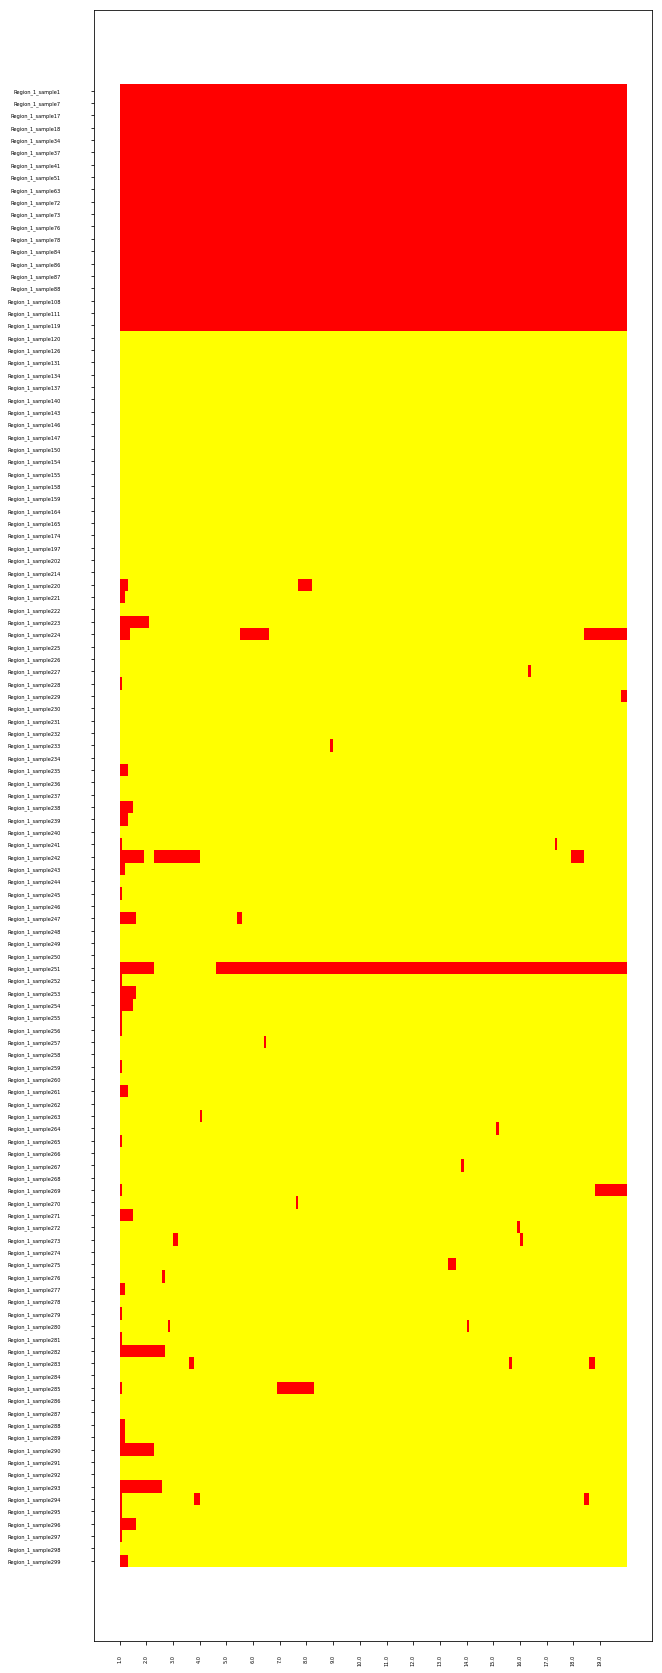

In [8]:

Comparison_threshold= 5
Outlier_threshold= 1e-7

import re
chromosome_list= []
chromosomes= [1]


for hap in Admix_indexes:
    Subject = 'sample' + str(hap)
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])

ideo = pd.DataFrame(Ideo,columns = ['chrom', 'start', 'end', 'gieStain'])


# Filter out chromosomes not in our list
ideo = ideo[ideo.chrom.apply(lambda x: x in chromosome_list)]

ideo = Modules_tools.compress_ideo_vII(ideo,Out,chromosome_list)

fig= Modules_tools.return_ideogram(ideo,chromosome_list,Comparison_threshold,Outlier_threshold)


adding ideograms...


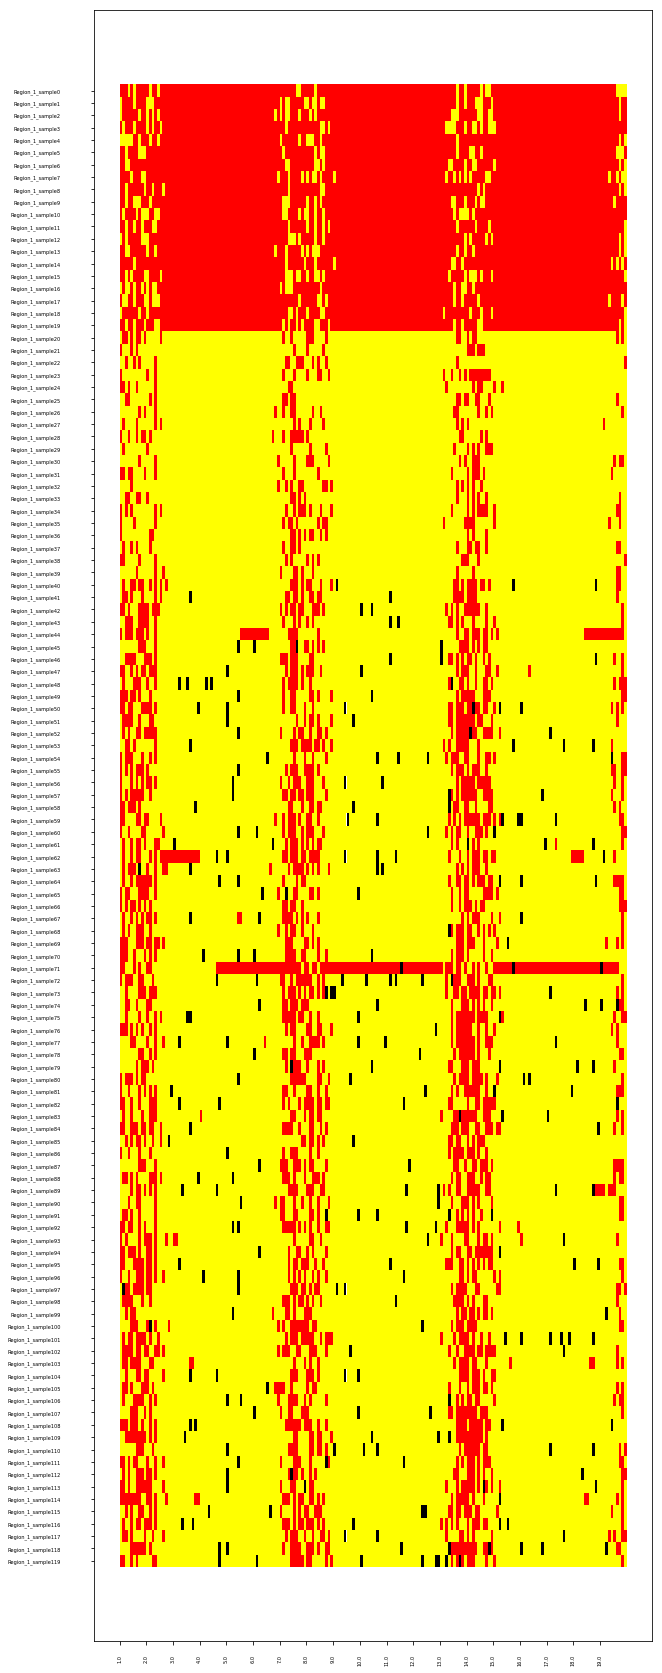

In [11]:

############ KDE NO FILTER
############


focus_indexes= Admix_indexes

Comparison_threshold= 1
Outlier_threshold= 1e-7
color_ref= ['red','yellow','black','orange','orange','purple','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

Blocks2 = Modules_tools.Merge_class(Windows,focus_indexes,Out,Comparison_threshold,Outlier_threshold)

Ideo_KDE = []
chromosome_list= []
chromosomes= Blocks.keys()

for here in range(len(Admix_indexes)):
    Subject = 'sample' + str(here)
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,Out[Chr][bl],color_ref[Blocks2[Chr][bl][here] - 1]] for bl in sorted(Blocks2[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_KDE.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_kde = pd.DataFrame(Ideo_KDE,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_kde = ideo_kde[ideo_kde.chrom.apply(lambda x: x in chromosome_list)]

ideo_kde = Modules_tools.compress_ideo_vII(ideo_kde,Out,chromosome_list)

fig= Modules_tools.return_ideogram(ideo_kde,chromosome_list,Comparison_threshold,Outlier_threshold)



In [ ]:

########## LOTER
##########

Snps= [np.linspace(x,Out[1][x],L) for x in Out[1].keys()]
Snps= [int(x) for x in it.chain(*Snps)]
Snps= sorted(Snps)

import loter.locanc.local_ancestry as lc

res_loter= lc.loter_smooth([Gp1,Gp2],All)


def return_loter_blocks(loter_data,snps):
    '''
    Organise Loter ancestry assignment matrix into a Blocks type dictionary.
    '''
    loter_data= loter_data.T
    snp_count= 0
    Blocks= {}
    Out= {}
    
    current_snp= snps[0]
    current= loter_data[0,:]
    
    for x in range(1,loter_data.shape[0]):
        
        if sum(loter_data[x,:] != current) > 0: 
            Blocks[current_snp]= current
            Out[current_snp]= snps[x] - 1
            current_snp= snps[x]
            current= loter_data[x]
        if x == loter_data.shape[0]:
            Blocks[current_snp]= current
            Out[current_snp]= snps[x] - 1
    return Blocks, Out


loter_blocks, loter_out= return_loter_blocks(res_loter,Snps)

loter_blocks= {1:loter_blocks}
loter_out= {1:loter_out}

Ideo_loter = []
chromosome_list= []
chromosomes= loter_blocks.keys()

for here in range(len(Admix_indexes)):
    Subject = 'sample' + str(Admix_indexes[here])
    
    chromosome_list.extend(['Region_'+str(Chr)+ '_' + Subject for Chr in chromosomes])
    
    Stock = [[['Region_'+str(Chr)+ '_' + Subject,bl,loter_out[Chr][bl],color_ref[loter_blocks[Chr][bl][here]]] for bl in sorted(loter_blocks[Chr].keys())] for Chr in chromosomes]
    Stock = [y for y in it.chain(*[z for z in it.chain(*[Stock])])]
    
    Ideo_loter.extend(Stock)

#### begin by compressing assignments by individuals. Lightens the load of the following plot.
import re
ideo_loter = pd.DataFrame(Ideo_loter,columns = ['chrom', 'start', 'end', 'gieStain'])

# Filter out chromosomes not in our list
ideo_loter = ideo_loter[ideo_loter.chrom.apply(lambda x: x in chromosome_list)]

ideo_loter = compress_ideo(ideo_loter,loter_out,chromosome_list)

fig= return_ideogram(ideo_loter)

